<a href="https://colab.research.google.com/github/sg-56/ML-Zoomcamp-Homeworks/blob/main/ML_ZoomCamp_HW_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
import numpy as np

In [2]:
cols = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]

In [3]:
df = pd.read_csv("bank-full.csv",delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df = df[cols]

In [5]:
df.isna().sum()

,0
age,0
job,0
marital,0
education,0
balance,0
housing,0
contact,0
day,0
month,0
duration,0


In [6]:
X = df.drop(columns=['y'])
y = df['y']

In [7]:
y = y.map({
    'yes':1,
    'no':0
})

In [8]:
y.value_counts()

,count
y,
0,39922
1,5289


# Preparing the dataset

In [9]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=1)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)


(36168, 14) (9043, 14) (36168,) (9043,)
(27126, 14) (9042, 14) (27126,) (9042,)


In [10]:
print(f"Shape of train Set : X {X_train.shape}\t Y : {y_train.shape}")
print(f"Shape of test Set : X {X_test.shape}\t Y : {y_test.shape}")
print(f"Shape of Val Set : X {X_val.shape}\t Y : {y_val.shape}")

Shape of train Set : X (27126, 14)	 Y : (27126,)
Shape of test Set : X (9043, 14)	 Y : (9043,)
Shape of Val Set : X (9042, 14)	 Y : (9042,)


In [11]:
num_cols = X_train.select_dtypes(include='number').columns
num_cols

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

# Question 1: ROC AUC feature importance

age: 	 0.512185717527344
balance: 	 0.5888313805382317
day: 	 0.525957882383908
duration: 	 0.8147002759670778
campaign: 	 0.5714543015682159
pdays: 	 0.5901276247352144
previous: 	 0.5985653242764153


<Axes: >

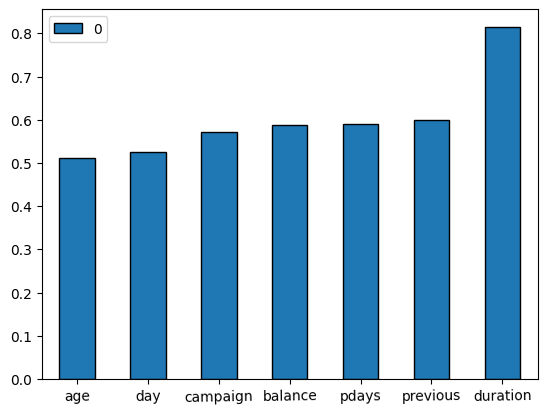

In [12]:
from sklearn.metrics import roc_auc_score
from collections import defaultdict
values = defaultdict(float)
for col in num_cols:
    model = LogisticRegression()
    model.fit(X_train[col].to_frame(),y_train.values)
    if col=='age':
        preds = model.predict_proba(-X_train[col].to_frame())
    else:
        preds = model.predict_proba(X_train[col].to_frame())
    # print(preds[:,:1])
    score = roc_auc_score(y_train,preds[:,1])
    print(f"{col}: \t {score}")
    values[col] = [score]

pd.DataFrame(values).T.sort_values(by=0).plot(kind='bar',rot=True,edgecolor='black')


# **Question** 2: Training the model

In [13]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse = False)
train_dict = X_train.to_dict(orient='records')
dv.fit(train_dict)
X_train_tr = dv.transform(train_dict)
X_val_tr = dv.transform(X_val.to_dict(orient='records'))

In [14]:

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_tr,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [15]:

preds = model.predict_proba(X_val_tr)
score = roc_auc_score(y_val,preds[:,1])
print(score)



0.9004159581551736


# Question 3: Precision and Recall

In [16]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [17]:
preds = model.predict(X_val_tr)
scores = tpr_fpr_dataframe(y_val,preds)
scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,1098,7944,0,0,1.000000,1.000000
1,0.01,373,192,725,7752,0.339709,0.024169
2,0.02,373,192,725,7752,0.339709,0.024169
3,0.03,373,192,725,7752,0.339709,0.024169
4,0.04,373,192,725,7752,0.339709,0.024169
...,...,...,...,...,...,...,...
96,0.96,373,192,725,7752,0.339709,0.024169
97,0.97,373,192,725,7752,0.339709,0.024169
98,0.98,373,192,725,7752,0.339709,0.024169
99,0.99,373,192,725,7752,0.339709,0.024169


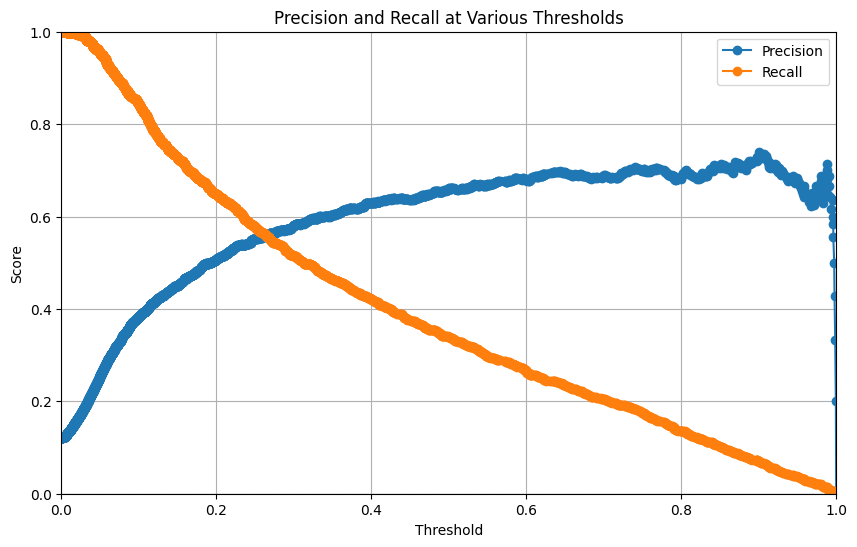

In [18]:
from sklearn.metrics import precision_recall_curve
y_scores = model.predict_proba(X_val_tr)

precision, recall, thresholds = precision_recall_curve(y_val, y_scores[:,1])
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', marker='o')
plt.plot(thresholds, recall[:-1], label='Recall', marker='o')
plt.title('Precision and Recall at Various Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.axhline(0, color='grey', lw=0.2, ls='--')
plt.axvline(0, color='grey', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()


# Question 4: F1 score

In [19]:

from sklearn.metrics import f1_score
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_scores >= threshold).astype(int)
    # Calculate the F1 score
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)


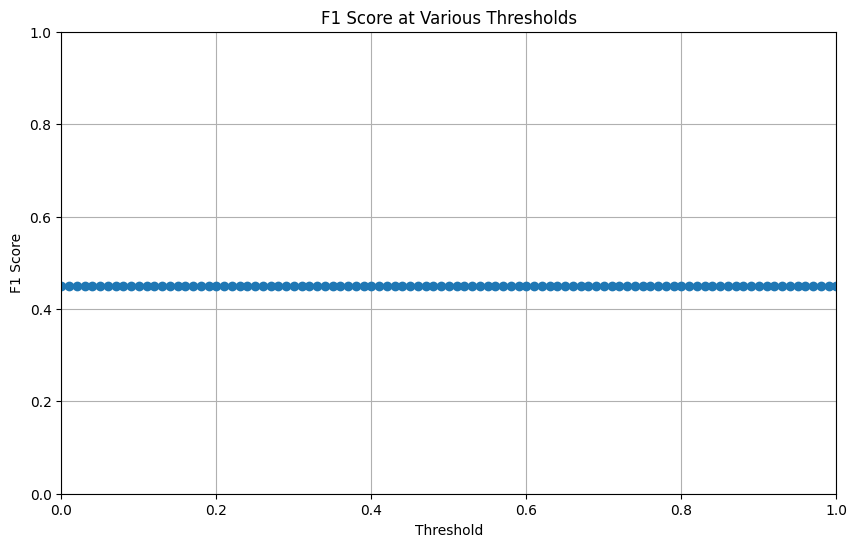

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1 Score at Various Thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.axhline(0, color='grey', lw=0.5, ls='--')
plt.axvline(0, color='grey', lw=0.5, ls='--')
plt.grid()
plt.show()


# Question 5: 5-Fold CV

In [22]:

from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score
kf = KFold(n_splits=5, shuffle=True, random_state=1)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

from sklearn.feature_extraction import DictVectorizer



In [23]:
auc_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    dv = DictVectorizer(sparse = False)
    train_dict = X_train.to_dict(orient='records')
    dv.fit(train_dict)
    X_train_tr = dv.transform(train_dict)
    X_val_tr = dv.transform(X_val.to_dict(orient='records'))
    # Train the model
    model.fit(X_train_tr, y_train)

    # Make predictions
    y_val_pred = model.predict_proba(X_val_tr)[:, 1]  # Probability of the positive class

    # Calculate AUC
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)

# Print the AUC scores for each fold
for i, score in enumerate(auc_scores, 1):
    print(f'Fold {i}: AUC = {score:.4f}')

# Print the average AUC across all folds
print(f'Average AUC: {np.mean(auc_scores):.4f}')



Fold 1: AUC = 0.9070
Fold 2: AUC = 0.8989
Fold 3: AUC = 0.9055
Fold 4: AUC = 0.9124
Fold 5: AUC = 0.9068
Average AUC: 0.9061


In [24]:
np.round(np.std(auc_scores),5)

0.00432

# Question 6: Hyperparameter Tuning

In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
C_values = [0.000001, 0.001, 1]


In [28]:
results = {}

for C in C_values:
    auc_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        dv = DictVectorizer(sparse = False)
        train_dict = X_train.to_dict(orient='records')
        dv.fit(train_dict)
        X_train_tr = dv.transform(train_dict)
        X_val_tr = dv.transform(X_val.to_dict(orient='records'))
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_tr, y_train)

    # Make predictions
        y_val_pred = model.predict_proba(X_val_tr)[:, 1]  # Probability of the positive class

    # Calculate AUC
        auc = roc_auc_score(y_val, y_val_pred)
        auc_scores.append(auc)

    # Calculate mean and std of AUC scores
        mean_auc = np.mean(auc_scores)
        std_auc = np.std(auc_scores)

    # Store results rounded to 3 decimal places
        results[C] = (round(mean_auc, 3), round(std_auc, 3))




In [29]:
# Print results
for C, (mean, std) in results.items():
    print(f'C = {C}: Mean AUC = {mean}, Std AUC = {std}')

C = 1e-06: Mean AUC = 0.705, Std AUC = 0.011
C = 0.001: Mean AUC = 0.868, Std AUC = 0.006
C = 1: Mean AUC = 0.906, Std AUC = 0.004
